<a href="https://www.kaggle.com/code/jesusgraterol/bitcoinfuturesliquidationprice?scriptVersionId=136310815" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bitcoin Futures Liquidation Price

When trading Bitcoin Futures Contracts, the allocated funds are used as collateral by the Exchange Platform in order to be able to open a position based on the desired leverage. If the asset's price moves against the position side strongly, past the liquidation price, The position is closed automatically and as a result, the collateral is used to pay the lenders and cover fees.

### Formula

The formula for calculating the liquidation price for a margin trade using currency "i" is as follows:

Here, "i" represents the currency "i", "Ai" represents the total amount of "i" assets, "Li" represents the borrowed amount of "x" asset, "Ri" represents the amount of interest payable on "x" asset, "Pi" represents the index price of the "x" asset/BTC (or USDT) pair, and finally "li" represents the liquidation price for "x" asset.

Liquidation is triggered when the risk ratio reaches the liquidation risk ratio .

Risk ratio = Total assets / (Total amount borrowed + Interest payable). Using the "i" currency as an example:

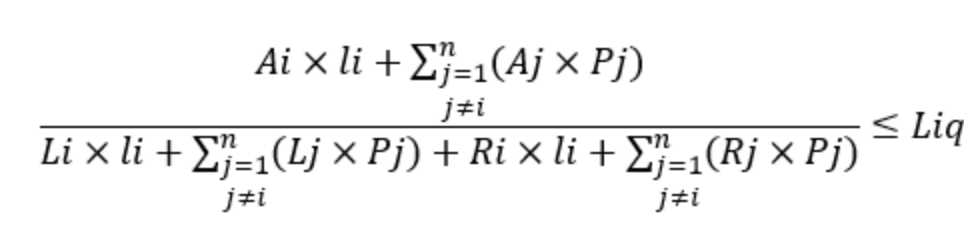

Therefore, the liquidation reference price for "i" currency is:

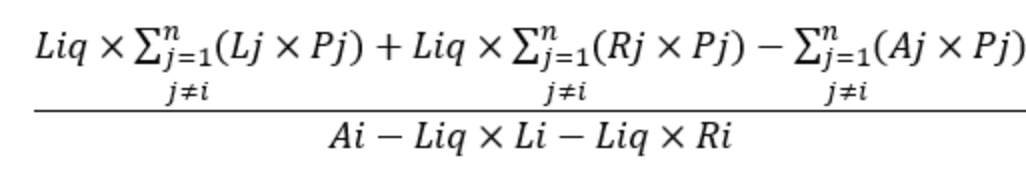

Ratio of the index price to the liquidation reference price = (Liquidation price - Index price) / Index price.

In [1]:
##################
## Dependencies ##
##################

from typing import List, TypedDict, Literal
import utilities as utils

In [2]:
###########
## Types ##
###########


# Exchanges makes use of the Margin Tiers Table in order to calculate the 
# funds required in order to open a position for a given leverage, as well
# as the liquidation price.
class ILeverageTier(TypedDict):
    # The size of the position used to derive the tier
    max_position: int
        
    # The maintenance margin & amount are calculated based on the positions 
    # at different notional value tiers.
    maintenance_margin: float
    maintenance_amount: int
        
        
# The interface of a trade that will help simplify the calculation
class ITrade(TypedDict):
    # The price at which the trade was executed
    price: float
        
    # The USD Amount that was longed or shorted
    amount: float

        
# The position skeleton to be calculated
class IPosition(TypedDict):
    # The side of the position. 1 Stands for LONG and -1 for SHORT.
    side: Literal[1, -1]
        
    # The leverage used to open the position
    leverage: float # <- Some exchanges accept decimal format
        
    # The list of trades that have been executed
    trades: List[ITrade]
        
        
        
# The configuration dictionary used to hold user input to prevent/limit the 
# editing of the source code.
class IConfig(TypedDict):
    leverage_tiers: List[ILeverageTier]
    position: IPosition

# Configuration

In [3]:
CONFIG: IConfig = {
    # Leverage Tiers Table
    # These values have been extracted from Binance through the following URL:
    # https://www.binance.com/en/futures/trading-rules/perpetual/leverage-margin
    # Keep in mind the exchange can change these parameters at any time.
    "leverage_tiers": [
        { "max_position": 50000,     "maintenance_margin": 0.4, "maintenance_amount": 0 },
        { "max_position": 250000,    "maintenance_margin": 0.5, "maintenance_amount": 50 },
        { "max_position": 1000000,   "maintenance_margin": 1,   "maintenance_amount": 1300 },
        { "max_position": 10000000,  "maintenance_margin": 2.5, "maintenance_amount": 16300 },
        { "max_position": 20000000,  "maintenance_margin": 5,   "maintenance_amount": 266300 },
        { "max_position": 50000000,  "maintenance_margin": 10,  "maintenance_amount": 1266300 },
        { "max_position": 100000000, "maintenance_margin": 12.5,"maintenance_amount": 2516300 },
        { "max_position": 200000000, "maintenance_margin": 15,  "maintenance_amount": 5016300 },
        { "max_position": 300000000, "maintenance_margin": 25,  "maintenance_amount": 25016300 },
        { "max_position": 500000000, "maintenance_margin": 50,  "maintenance_amount": 100016300 },
    ],
    
    # The position skeleton to be calculated
    "position": {
        "side": 1,
        "leverage": 10,
        "trades": [
            { "price": 27340, "amount": 100 },
            { "price": 22077, "amount": 200 },
            { "price": 21175, "amount": 400 },
            { "price": 22053, "amount": 800 },
            { "price": 21369, "amount": 1600 },
            { "price": 20924, "amount": 3200 },
            { "price": 20595, "amount": 6400 },
        ]
    }
}

# Calculator

In [4]:
# Init the position margin (USDT Balance added to the position on isolated mode)
position_margin: float = 0

# Init the BTC short/long contract quantity (Before applying leverage)
raw_contract_quantity: float = 0

# Iterate over each trade and calculate the entry price
for trade in CONFIG["position"]["trades"]:
  # Append the value to the position margin
  position_margin += trade["amount"]

  # Add the value to the raw contract quantity
  raw_contract_quantity += round(trade["amount"] / trade["price"], 8)

# Calculate the entry price
entry_price: float = round(position_margin / raw_contract_quantity, 2)

# Calculate the contract quantity (With leverage)
contract_quantity: float = round(raw_contract_quantity * CONFIG["position"]["leverage"], 8)

In [5]:
# Initialize the liquidation price
liquidation_price: float = 0

# Iterate over each leverage tier until the correct level is found
for tier in CONFIG["leverage_tiers"]:
  # Init the maintenance margin rate
  maintenance_margin_rate: float = tier["maintenance_margin"] / 100

  # Calculate the liquidation price
  liquidation_price = round(
      (position_margin + tier["maintenance_amount"] - (contract_quantity * CONFIG["position"]["side"]) * entry_price) / (contract_quantity * (maintenance_margin_rate - CONFIG["position"]["side"])), 
      2
  )

  # Calculate the base balance
  base_balance = liquidation_price * contract_quantity

  # If the correct tier has been found, stop the iteration
  if base_balance <= tier["max_position"]:
    break

In [6]:
print("RESULT\n\n")
print(f"Number of Trades: {len(CONFIG['position']['trades'])}")
print(f"\nEntry Price: {utils.currency(entry_price)}")
print(f"\nPosition Margin: {utils.currency(position_margin)}")
print(f"\nContract Quantity: {utils.currency(raw_contract_quantity, symbol='BTC')} ({utils.currency(position_margin)}) x{CONFIG['position']['leverage']} -> {utils.currency(contract_quantity, symbol='BTC')} ({utils.currency(round(position_margin*CONFIG['position']['leverage'], 2))})")
print(f"\nLiquidation Price: {utils.currency(liquidation_price)} -> {utils.calculate_percentage_change(entry_price, liquidation_price)}% away from entry")

RESULT


Number of Trades: 7

Entry Price: 20,941.63$

Position Margin: 12,700$

Contract Quantity: 0.60644757BTC (12,700$) x10 -> 6.0644757BTC (127,000$)

Liquidation Price: 18,933.89$ -> -9.59% away from entry
